# AI CALCULATOR

## Libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import shutil # copy, move file
import os # miscellaneous operation system interfaces
import pathlib
import random
import numpy as np

%matplotlib inline


# !pip install tensorflow-gpu==2.0.0-beta1
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

## Path lead to photos

In [2]:
data_root = pathlib.Path('./data')

#### Take all images and paths lead to these images

In [3]:
# Find all image's path
all_image_paths = list(data_root.glob("*/*"))
all_image_paths = [str(path) for path in all_image_paths if path.is_file()]
random.shuffle(all_image_paths)

#### Total images

In [4]:
image_count = len(all_image_paths)
image_count

19460

In [5]:
for index, image_path in enumerate(all_image_paths):
    if (image_path.split('.')[1] != "DS_Store") :
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
        except:
            print(all_image_paths[index])
        if index % 3000 == 0: 
            print(index)
    else:
        all_image_paths.remove(image_path)

0
3000
6000
9000
12000
15000
18000


### Take labels

In [6]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# label_names.remove('.ipynb_checkpoints')
label_names = np.array(label_names)
label_names

array(['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='<U2')

### Set index for labels

In [7]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12}

### Set label for each image

In [8]:
# Find all image's labels
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [4, 4, 5, 12, 2, 4, 7, 4, 6, 0]


### Count amount per class

In [9]:
# Count #image each class
from collections import Counter
count = Counter()

for label in all_image_labels:
    count[label_names[label]] += 1
  
count

Counter({'12': 2927,
         '2': 901,
         '9': 544,
         '10': 3771,
         '4': 993,
         '3': 814,
         '0': 1266,
         '5': 909,
         '6': 1614,
         '11': 3042,
         '1': 1435,
         '7': 529,
         '8': 704})

## Functions

In [10]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    image = (255 - image)/255.0

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

data/10/exp17509.jpg


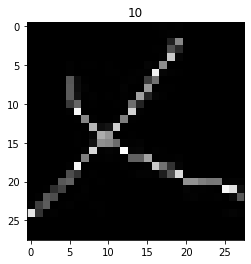

In [11]:
index = random.randint(0, image_count)
image_path = all_image_paths[index]
label = all_image_labels[index]

print(image_path)

plt.imshow(load_and_preprocess_image(image_path)[:,:,0], cmap='gray')
plt.grid(False)
plt.title(label_names[label].title())
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, all_image_labels, test_size=0.2, random_state=101)

In [13]:
test_image_paths[0]
test_image_labels[0]

7

In [14]:
# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_ds(all_image_paths, all_image_labels):
    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    image_label_ds = ds.map(load_and_preprocess_from_path_label)

    # Setting a shuffle buffer size as large as the dataset ensures that the data is
    # completely shuffled.
    ds = image_label_ds.shuffle(buffer_size=image_count)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [15]:
train_set = create_ds(train_image_paths, train_image_labels)
test_set = create_ds(test_image_paths, test_image_labels)

## Model summary

In [17]:
cnn_model = tf.keras.Sequential(
  [
#       tf.keras.layers.Reshape(input_shape=(28,28), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same', input_shape=(28, 28, 1)),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(len(label_names), activation='softmax')
  ])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          2

In [18]:
# mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
# mobile_net.trainable=False

# model = tf.keras.Sequential([
#     mobile_net,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

# base_learning_rate = 0.0001
# model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#               loss='sparse_categorical_crossentropy',
#               metrics=["accuracy"])

# model.summary()

## Customized Callback

In [19]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
#         self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])
#         self.model.reset_metrics()


## TRAINING

In [20]:
# steps_per_epoch = tf.math.ceil(0.9 * image_count/BATCH_SIZE).numpy()
# val_steps_per_epoch = tf.math.ceil(0.1 * image_count/BATCH_SIZE).numpy()

steps_per_epoch = len(train_image_labels) // BATCH_SIZE
val_steps_per_epoch = len(test_image_labels) // BATCH_SIZE
batch_stats_callback = CollectBatchStats()

history = cnn_model.fit(train_set, epochs=6, 
            steps_per_epoch=steps_per_epoch,
            callbacks = [batch_stats_callback],
            validation_data=test_set,
            validation_steps=val_steps_per_epoch)

Epoch 1/6


W1218 11:35:06.953776 4456744384 deprecation.py:323] From /Users/hoahh2201/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


486/486 [==============================] - 38s 78ms/step - loss: 0.1845 - accuracy: 0.9443 - val_loss: 0.0416 - val_accuracy: 0.9876
Epoch 2/6
486/486 [==============================] - 28s 57ms/step - loss: 0.0433 - accuracy: 0.9869 - val_loss: 0.0507 - val_accuracy: 0.9858
Epoch 3/6
486/486 [==============================] - 26s 53ms/step - loss: 0.0305 - accuracy: 0.9904 - val_loss: 0.0373 - val_accuracy: 0.9886
Epoch 4/6
486/486 [==============================] - 27s 56ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.0717 - val_accuracy: 0.9848
Epoch 5/6
486/486 [==============================] - 26s 54ms/step - loss: 0.0300 - accuracy: 0.9909 - val_loss: 0.0834 - val_accuracy: 0.9804
Epoch 6/6
486/486 [==============================] - 26s 53ms/step - loss: 0.0203 - accuracy: 0.9941 - val_loss: 0.0304 - val_accuracy: 0.9920


In [22]:
def plot_loss(training_losses, val_losses, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Loss")
    plt.xlabel(x_label)
    
    training_steps = len(training_losses)
    test_steps = len(val_losses)
    plt.plot(training_losses, label='Training Loss')
    plt.plot(np.linspace(0, training_steps, test_steps), val_losses, label='Validation Loss')
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc='upper right')
    plt.show()

In [23]:
def plot_accuracy(training_acc, val_acc, x_label='Training Steps'):
    plt.figure()
    plt.ylabel("Accuracy")
    plt.xlabel(x_label)
    
    training_steps = len(training_acc)
    test_steps = len(val_acc)
    plt.plot(training_acc, label='Training Accuracy')
    plt.plot(np.linspace(0, training_steps, test_steps), val_acc, label='Validation Accuracy')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.show()

<Figure size 432x288 with 0 Axes>

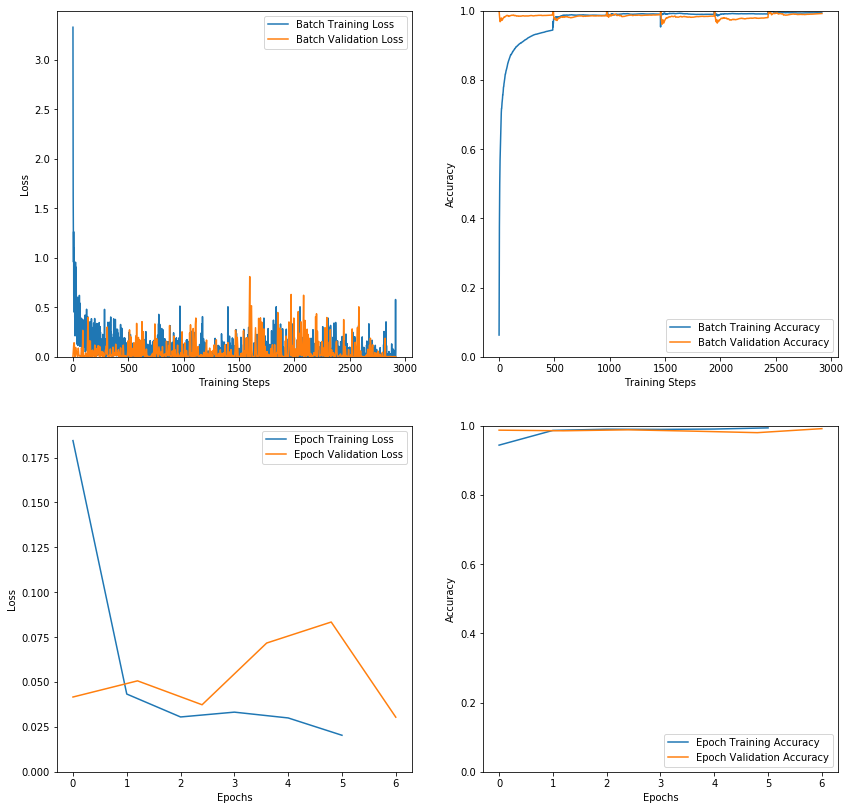

In [24]:
def plot_training_results(training_acc, training_losses, val_acc, val_losses, epoch_acc, epoch_val_acc, epoch_loss, epoch_val_loss):
    plt.figure()
    fig, ax = plt.subplots(2, 2, figsize=[14, 14])

    # Plot batch's training & validation losses
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].set_xlabel("Training Steps")

    training_steps = len(training_losses)
    test_steps = len(val_losses)
    ax[0, 0].plot(training_losses, label='Batch Training Loss')
    ax[0, 0].plot(np.linspace(0, training_steps, test_steps), val_losses, label='Batch Validation Loss')
    ax[0, 0].set_ylim([0,max(ax[0, 0].set_ylim())])
    ax[0, 0].legend(loc='upper right')

    # Plot batchs training & validation accuracy
    ax[0, 1].set_ylabel("Accuracy")
    ax[0, 1].set_xlabel("Training Steps")

    training_steps = len(training_acc)
    test_steps = len(val_acc)
    ax[0, 1].plot(training_acc, label='Batch Training Accuracy')
    ax[0, 1].plot(np.linspace(0, training_steps, test_steps), val_acc, label='Batch Validation Accuracy')
    ax[0, 1].set_ylim([0,1])
    ax[0, 1].legend(loc='lower right')

    # Plot epochs training & validation losses
    ax[1, 0].set_ylabel("Loss")
    ax[1, 0].set_xlabel("Epochs")

    train_epochs = len(epoch_loss)
    val_epochs = len(epoch_val_loss)
    ax[1, 0].plot(epoch_loss, label='Epoch Training Loss')
    ax[1, 0].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_loss, label='Epoch Validation Loss')
    ax[1, 0].set_ylim([0,max(ax[1, 0].set_ylim())])
    ax[1, 0].legend(loc='upper right')

    # Plot epochs training & validation accuracy
    ax[1, 1].set_ylabel("Accuracy")
    ax[1, 1].set_xlabel("Epochs")

    train_epochs = len(epoch_acc)
    val_epochs = len(epoch_val_acc)
    ax[1, 1].plot(epoch_acc, label='Epoch Training Accuracy')
    ax[1, 1].plot(np.linspace(0, train_epochs, val_epochs), epoch_val_acc, label='Epoch Validation Accuracy')
    ax[1, 1].set_ylim([0,1])
    ax[1, 1].legend(loc='lower right')

    plt.show()

plot_training_results(batch_stats_callback.batch_acc,
                      batch_stats_callback.batch_losses, 
                      batch_stats_callback.batch_val_acc, 
                      batch_stats_callback.batch_val_losses,
                      history.history['accuracy'],
                      history.history['val_accuracy'],
                      history.history['loss'],
                      history.history['val_loss']
                     )

## Testing and preview

In [25]:
# Take 1 batch out to test

for image_batch, label_batch in test_set:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 28, 28, 1)
Label batch shape:  (32,)


In [26]:
# Predict
label_names = np.array(label_names)
predicted_batch = cnn_model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)
predicted_label_batch = label_names[predicted_id]

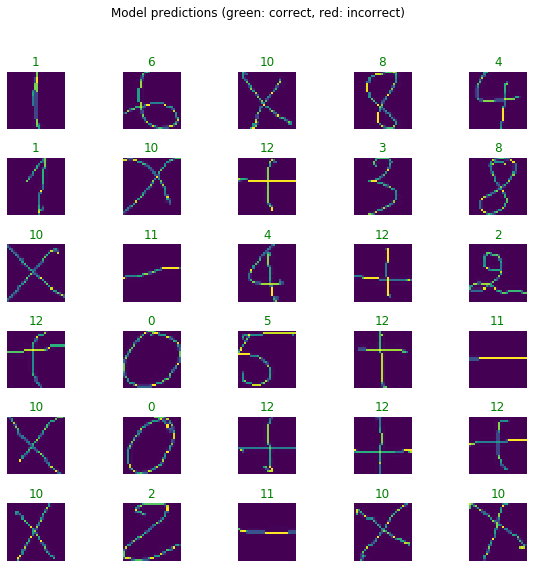

In [27]:
# Plot the result

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n][:,:,0])
    color = "green" if predicted_id[n] == label_batch.numpy()[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [29]:
count = 0
print(len(predicted_label_batch))
for i in range(len(predicted_label_batch)):
    if predicted_label_batch[0] == label_names[predicted_id][0]: count +=1
print(count)

32
32


## Export model

In [30]:
# Export model
cnn_model.save('./plus_minus_times_div.h5')

In [32]:
# Test model

reloaded_model = tf.keras.models.load_model('./plus_minus_times_div.h5')
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 12)        36        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          2

In [33]:
result_batch = cnn_model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [34]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [35]:

# loss, accuracy = cnn_model.evaluate(test_set)
# print('loss: ', loss, '\naccuracy: ', accuracy)

In [36]:
def deskew(image, width):
    (h, w) = image.shape[:2]
    moments = cv2.moments(image)

    skew = moments['mu11'] / moments['mu02']
    M = np.float32([[1, skew, -0.5*w*skew],
                    [0, 1, 0]])
    image = cv2.warpAffine(image, M, (w, h), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

    image = imutils.resize(image, width=width)

    return image
def center_extent(image, size):
    (eW, eH) = size

    if image.shape[1] > image.shape[0]:
        image = imutils.resize(image, width=eW)
    else:
        image = imutils.resize(image, height=eH)

    extent = np.zeros((eH, eW), dtype='uint8')
    offsetX = (eW - image.shape[1]) // 2
    offsetY = (eH - image.shape[0]) // 2
    extent[offsetY:offsetY + image.shape[0], offsetX:offsetX+image.shape[1]] = image

    CM = mahotas.center_of_mass(extent)
    (cY, cX) = np.round(CM).astype("int32")
    (dX, dY) = ((size[0]//2) - cX, (size[1] // 2) - cY)
    M = np.float32([[1, 0, dX], [0, 1, dY]])
    extent = cv2.warpAffine(extent, M, size)

    return extent